# Statistics

---

### Names: [name here]

**Before you do anything else, go to File -> Save a Copy in Drive. Make any requested edits to that copy.**

This lab explores probability distributions, how they can be propogated through an equation, and how we can use estimates of uncertainties in our data to find significant emission features.

#### New Code:

This lab will introduce a number of different pieces of code, including code that can:


*   Draw random numbers from a Poisson distribution
*   Draw random numbers from a Gaussian distribution
* `==`, `!=`, `>`, `<`, `<=`, `>=`, `&`, `|`
* Select out points in a numpy array based on certain criteria. 
* Plot data points with error bars

---




In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib inline

#!pip install git+http://github.com/astropy/astroquery.git#egg=astroquery
import warnings
warnings.filterwarnings('ignore',module='astropy.io.votables.tree')
warnings.filterwarnings('ignore',message='.*unclosed..socket')

import astropy.units as u
from astropy.coordinates import SkyCoord, ICRS
from astroquery.sdss import SDSS #package that allows queries of the SDSS database

### Identifying statistically significant features

One important problem in astronomy, and in many other fields, is determining if there is a real signal in your data. For astronomy that can mean knowing whether you have detected a particular star in an image, if you have detected an absorption or emission line within a spectrum, or if you have detected a change in brightness in a light curve due to e.g. the transit of a planet. You can determine if the signal is statistically significant (i.e., the signal is highly unlikely to be cause by random fluctuations in the background noise) if you have a good estimate of the background flux and the noise. But sometimes these can be hard to measure.

Below you will explore this using the light curve (i.e., measurements of flux at different times) measured by the Kepler space telescope for a young star. The code block below reads in the light curve (make sure to upload the necessary fits file from Glow) and it populates three numpy arrays:


*   `time`: Modified Julian Date at which the observations were taken. The modified Julian Date is the number of days since midnight on Nov 17, 1858, written in decimal form.
*   `flux`: The flux during each observations
*   `flux_err`: The uncertainty in each flux observation.


In [2]:
image = fits.open('EPIC203954898_kepler_llc.fits')
time, flux, flux_err = [], [], []
for i in image[2].data:
  time.append(i[0])
  flux.append(i[1])
  flux_err.append(i[2])
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)
image.close()

> **Q:** Plot the light curve (time vs flux) for this object. Label the axes. Print out the mean and standard deviation ($\sigma$). To the graph, add a horizontal line indicating the mean+3$\sigma$.

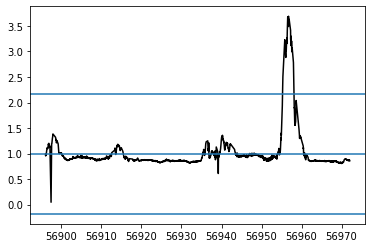

In [3]:
# Plot the light curve
plt.plot(time,flux,color='k')
plt.axhline(np.mean(flux))
plt.axhline(np.mean(flux)+3*np.std(flux))
plt.axhline(np.mean(flux)-3*np.std(flux))

If we assume the noise on the flux is a Gaussian distribution, then we could use Gaussian statistics to determine the probability of each peak (or conversely, set a threshold above which any features are highly unlikely to be due to random chance). But calculating the mean and standard deviation directly from all of the data is skewed by the outbursts themselves.


What we want is to select out relatively smooth regions of the light curve, and calculate the mean and standard deviation from those regions. To do this we can take advantage of logical operators in python, and the combination of boolean arrays with numpy arrays.

If we use a statement like:

```
late = time>56965
```

the variable `late` will have the same shape as `time` but each element will be either `True` or `False`, depending on whether or not that element satisfies the logical condition. Note that this only works for numpy arrays, and will fail for lists or tuples. 

The following code prints out each element of `time`, and the corresponding element of the array `late`. To demonstrate what this looks like. For every element of `time` that is greater than `56965` the corresponding entry in `late` will be `True`, otherwise it will be `False`.

In [4]:
late = time>56965
for i in range(len(time)):
    print(time[i],late[i])

56896.00170910173 False
56896.042573410436 False
56896.063005564094 False
56896.08343771729 False
56896.10386997001 False
56896.124302122735 False
56896.14473417453 False
56896.16516642585 False
56896.18559857672 False
56896.20603062758 False
56896.22646287751 False
56896.246894926975 False
56896.26732707644 False
56896.28775932497 False
56896.30819137351 False
56896.32862352111 False
56896.34905576871 False
56896.36948781585 False
56896.38991996206 False
56896.41035220826 False
56896.430784254 False
56896.45121639928 False
56896.47164864408 False
56896.49208078843 False
56896.512512932306 False
56896.53294507571 False
56896.55337721866 False
56896.57380936114 False
56896.59424150315 False
56896.65553792687 False
56896.67597006749 False
56896.69640230718 False
56896.71683434686 False
56896.737266485616 False
56896.75769872437 False
56896.77813076266 False
56896.79856290002 False
56896.81899513738 False
56896.839427174265 False
56896.859859310694 False
56896.88029154665 False
56896.9007

56915.90244378726 False
56915.922875684686 False
56915.94330748164 False
56915.9637391786 False
56915.9841710751 False
56916.004602871355 False
56916.025034567385 False
56916.04546646295 False
56916.06589825851 False
56916.08632995361 False
56916.106761848474 False
56916.1271936431 False
56916.14762533727 False
56916.168057231436 False
56916.18848902513 False
56916.55626146563 False
56916.57669315398 False
56916.59712494232 False
56916.6175567302 False
56916.63798851808 False
56916.658420205495 False
56916.67885209267 False
56916.69928387939 False
56916.7197155661 False
56916.74014745235 False
56916.78101102415 False
56916.8014428097 False
56916.82187459502 False
56916.8423063801 False
56916.862738164724 False
56916.88316994911 False
56916.924033617186 False
56916.944465300876 False
56916.964897184094 False
56916.98532896732 False
56917.80260017153 False
56917.823031943815 False
56917.84346371563 False
56917.86389548745 False
56917.88432725879 False
56917.90475912991 False
56917.986486

56933.555437091185 False
56933.57586882213 False
56933.59630045297 False
56933.6167319838 False
56933.637163714404 False
56933.65759534501 False
56933.67802687538 False
56933.698458605744 False
56933.718890236 False
56933.73932196613 False
56933.75975349627 False
56933.780185126176 False
56933.800616756074 False
56933.82104838575 False
56933.84147991542 False
56933.86191164497 False
56933.88234327441 False
56933.90277480385 False
56933.92320653305 False
56933.94363816226 False
56933.96406979135 False
56933.98450142032 False
56934.004933049175 False
56934.02536477792 False
56934.04579630665 False
56934.06622793528 False
56934.08665966367 False
56934.107091292055 False
56934.12752282045 False
56934.14795454861 False
56934.16838617676 False
56934.188817704686 False
56934.20924943261 False
56934.22968106053 False
56934.25011278823 False
56934.270544315805 False
56934.290975943375 False
56934.33183919818 False
56934.3522708254 False
56934.37270255263 False
56934.43399733361 False
56934.4544

56962.73182013618 False
56962.752251855025 False
56962.772683574214 False
56962.79311529353 False
56962.81354701319 False
56962.87484227322 False
56962.89527399369 False
56962.915705614396 False
56962.93613743534 False
56962.956569156624 False
56962.97700077803 False
56962.99743259967 False
56963.01786422154 False
56963.03829604365 False
56963.05872776599 False
56963.07915938855 False
56963.09959121136 False
56963.12002293428 False
56963.14045455754 False
56963.16088638105 False
56963.181318104784 False
56963.20174992875 False
56963.22218155295 False
56963.24261327738 False
56963.263045102045 False
56963.283476726945 False
56963.30390845208 False
56963.36520362887 False
56963.38563545493 False
56963.406067181226 False
56963.42649890775 False
56963.44693063451 False
56963.46736236151 False
56963.48779418873 False
56963.50822581619 False
56963.52865754389 False
56963.54908937181 False
56963.6103845571 False
56963.63081618607 False
56963.651248015165 False
56963.67167964448 False
56963.69

One advantage of defining the variable `late` is that it can be passed to the variable `time` as you would any index. The result will select out the elements in `time` where `late` is True.

In [5]:
print(time[late])

[56965.02017472 56965.04060647 56965.06103821 56965.08147006
 56965.10190171 56965.12233345 56965.1427653  56965.16319695
 56965.18362869 56965.20406054 56965.22449229 56965.24492404
 56965.26535579 56965.32665104 56965.34708278 56965.36751463
 56965.38794629 56965.40837814 56965.42880989 56965.44924154
 56965.46967339 56965.49010514 56965.51053679 56965.57183205
 56965.5922639  56965.61269565 56965.63312741 56965.65355916
 56965.67399082 56965.69442267 56965.71485442 56965.73528618
 56965.75571793 56965.77614969 56965.8170132  56965.83744495
 56965.85787681 56965.87830857 56965.89874022 56965.91917208
 56965.93960384 56965.9600356  56965.98046735 56966.00089911
 56966.06219439 56966.08262625 56966.10305791 56966.12348977
 56966.14392153 56966.16435319 56966.18478505 56966.20521681
 56966.22564847 56966.24608033 56966.30737561 56966.32780728
 56966.34823914 56966.3686709  56966.40953443 56966.42996619
 56966.45039796 56966.47082972 56966.49126148 56966.55255678
 56966.57298864 56966.59

Another helpful feature of these boolean arrays is that True is equivalent to 1 while False is equivalent to 0. This means that we can quickly find out how many elements within `time` satisfy our condition by summing `late`.

In [ ]:
print('Number of elements with time>26965: ',late.sum())

This selection can also be applied to other arrays that have the same shape at `time`. For example, `flux[late]` selects out the flux values that have time>56965. In this way you can select out a range of times in the light curve, and then utilize the fluxes from those times.

In selecting out time frames, it may be helpful to use comparison operators:


*   `==` equal
*   `!=` not equal
*   `>` greater than
*   `<` less than
*   `>=` greater than or equal
*   `<=` less than or equal

and bitwise logical operators

* `&` and: Returns true if both statements are true
* `|`  or: Returns true if either statement is true

This allows us to select out multiple regions of the light curve, e.g.:

```
my_selection = ((time > 56900) & (time < 56950)) | (time > 56965)
``` 

The above code selects out those times that are between 56900 and 56950 or greater than 56965. 

>**Q:** Select out a time frame, or a set of time frames, within the light curve in which there are no obvious outbursts. Estimate the mean and standard deviation ($\sigma$) from these quiescent regions of the light curve. Plot the light curve, along with a horizontal line marking the value that is 3$\sigma$ above the mean. Any outburst that has a signal larger than this horizontal line is considered real (i.e. is not a product of noise in the data). 




1178
0.8738341009677569 0.032283348458592265


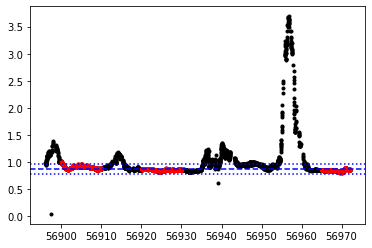

In [6]:
# Insert code here

mid = ((time>56920) & (time<56930)) | ((time>56900) & (time<56910)) | (time>56965)
print (mid.sum())

m,s = np.mean(flux[mid]),np.std(flux[mid])
print(m,s)

plt.plot(time,flux,'.k')
plt.plot(time[mid],flux[mid],'.r')
plt.axhline(m,ls='--',color='b')
plt.axhline(m+3*s,ls=':',color='b')
plt.axhline(m-3*s,ls=':',color='b')

>**Q:** What is the error on the mean that you just calculated?

**[insert answer here]**

>**Q:** There are 2863 data points in this light curve. If the signal was purely random noise, how many data points would exceed our 3 sigma threshold just based on random chance?

**[insert answer here]**

Above you estimated the uncertainty in the data by calculating the standard deviation in a region of the light curve where there was no significant signal. You can do a similar thing with images. By selecting out a region of the image that does not have any emission from stars, nebula, etc. you can estimate the average background value (which you need to subtract off from your signal) and the uncertainty. 

Go back to your code for calculating the light curve for the M101 supernova, from lab 4. 

> Copy that code and paste it into the empty code block below.

Now you will modify the code to calculate the uncertainties in light curve, and use these uncertainties to tell if the flux has returned to its pre-outburst level.

> Identify a region within the images in which there is no emission from the galaxy, or any stars. This will serve as the background. For each image, calculate the median and standard deviation in this background region. This represents the typical background level and noise. 

> **Q:** What are the background levels and noise values for each image? Are they the same or different?

**[insert answer here]**

> **Q:** The noise that you calculated is the noise per pixel. But you calculate the flux over many pixels. If the noise per pixel is $\sigma$, what is the noise level is $N$ pixels?

**[insert answer here]**

> **Q:** What is the flux of the supernova on each day? What is the uncertainty on that flux?

**[insert answer here]**

-15.019533308312333


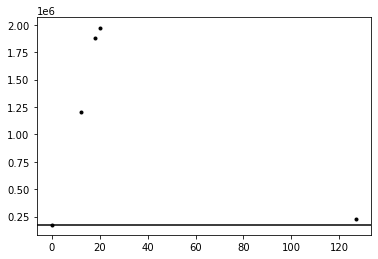

In [7]:
files = ['M101_%01d_proc.fits' % i for i in range(1,6)]
xranges = [[610,635],[605,630],[610,635],[612,637],[635,660]]
yranges = [[300,320],[305,325],[310,330],[310,330],[345,365]]
fluxes = []
dates = []
uncs = []

for i in range(5):
    image = fits.open(files[i])
    hdr = image[0].header
    data = image[0].data
    dates.append(hdr['jd'])
    
    bkg = data[800:950,200:350]
    fluxes.append(np.sum(data[xranges[i][0]:xranges[i][1],yranges[i][0]:yranges[i][1]]-np.median(bkg)))
    uncs.append(np.std(bkg)*np.sqrt(30*20))
    
dates = np.array(dates)
plt.errorbar(dates-dates[0],fluxes,yerr=uncs,fmt='.k')

print((fluxes[0]-fluxes[-1])/np.sqrt(uncs[0]**2.+uncs[-1]**2.))
plt.axhline(fluxes[0],color='k')

To plot the data with error bars we need to use a new plotting routine:

`plt.errorbar(xvals,yvals,yerr=yerrs,fmt='.k')`

The `plt.errorbar` function will plot data with error bars. This function takes as inputs the x and y values of the data. The uncertainties in the y-direction (`yerrs`) are sent using the optional keyword `yerr`. The `fmt` keyword sets the format of the plot points; in the example above that is black small dots.

> **Q:** Plot the light curve with error bars for the M101 supernova. Add a horizontal line at the pre-supernova level. 

> **Q:** Is the final flux consistent with the pre-supernova flux level? This will be the case if the difference between the final flux level and the pre-supernoa flux level is less than three times the noise. The noise in this case is the combination of the noise from the two flux measurements ($\sigma = \sqrt{\sigma_{pre-sn}^2+\sigma_{final}^2}$, where $\sigma_{pre-sn}$ is the noise in the pre-supernova flux measurement, and $\sigma_{final}$ is the noise in the final flux measurement.)

**[insert answer here]**

### Probability Distributions

If we repeat an experiment many times (e.g., take many image of a star and measure its flux in each image) we will not obtain the exact same result every time. Instead we will obtain a range of different values, and the relative probability of each of these values is given by a probability distribution. Python has built-in functions that allow us to draw values from a Poisson or Gaussian distribution. This can be useful if we want to model an experiment, or estimate the relative probability of obtaining different values.

Lets first look at a Poisson distribution. Remember that the Poisson distribution is defined for integer values and is given by :

$P(x,\mu ) = \frac{\mu^x}{x!}\exp^{-\mu}$

where $\mu$ is the average value of the distribution. Poisson distributions apply to counting statistics, e.g. counting the number of photons that arrive at our detector.

Within python, we can draw a random number from a Poisson distribution. If we do this a larger number of times, and plot a histogram of the different values drawn from this distribution, we can visualize the Poisson distribution.

Text(0.5, 1.0, 'Poisson Distribution')

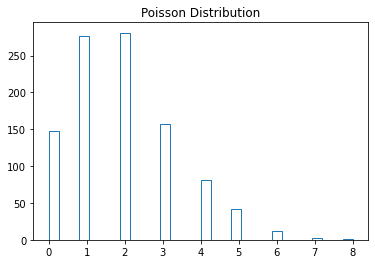

In [8]:
# The next line sets the average value
mu = 2

# The next line draws 1000 random number from a Poisson distribution
poiss_data = np.random.poisson(mu,size=1000) #<- the size parameter sets the number of random numbers drawn from the given distribution

# The next lines plot a historgram of the random numbers 
p = plt.hist(poiss_data,30,histtype='step')
plt.title('Poisson Distribution')

Next, lets look at a Gaussian distribution. The formula for a Gaussian distribution is:

$P(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}}\exp^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} $

where $\mu$ is the mean of the distribution and $\sigma$ is the standard deviation.

As with the Poisson distribution, we can draw random numbers from a Gaussian distribution. If we draw enough random numbers from this distribution, and plot a histogram of the result, we can visualize the Gaussian distribution.

Text(0.5, 1.0, 'Gaussian Distribution')

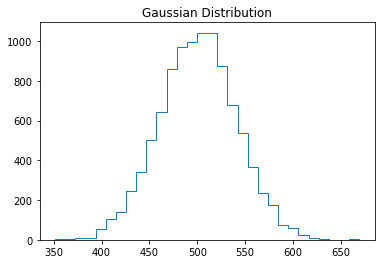

In [9]:
# Gaussian distribution
mean, std = 500, 40

# Draw 10000 random numbers from a Gaussian distribution
gauss_data = np.random.normal(mean,std,size=10000)

p = plt.hist(gauss_data,30,histtype='step')
plt.title('Gaussian Distribution')

Lets go through an exercise where we use the ability to generate random numbers.

The distance to a nearby object can be derived from the parallax by the following formula:

$d = 1/p$

where $d$ is the distance in units of parsecs and $p$ is the parallax angle, in the units of arc-seconds. As you saw in the databases lab, *Gaia* is a European space telescope that has measured the parallaxes for over one billion stars. They discourage derving the distance directly from objects with an error on the parallax of larger than 20%, but instead they suggest working directly with the parallax. Why is this?

Lets consider the star 55 Cnc. According to Gaia, it has p = 0.079427$\pm$0.000077 arc-seconds.

> **Q:** Using the formula for distance, and what you know about error propogation, calculate the distance to 55 Cnc, and its uncertainty.

**[Insert answer here]**

We can estimate the answer to the above question using random numbers. We first draw many random numbers from a Gaussian distribution with a mean and standard deviation given by the parallax measurement and its uncertainty. We then apply the distance formula to these values, and look at the the resulting distribution.

> **Q:** The code below performs this operation, but is missing important pieces, and contains some syntax errors. Fill in the missing pieces and fix the errors.

Distance to 55 Cnc 12.590+-0.012 pc


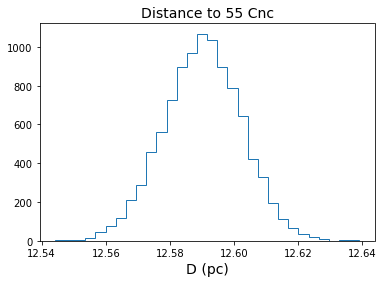

In [10]:
p_mean = 0.079427
p_std = 0.000077

p_gauss = np.random.normal(p_mean,p_std,size=10000) #Insert code to draw 1000 random number from a Gaussian distribution with a mean of p_mean and a standard deviation of p_std
d_gauss = 1/p_gauss

# Plot a histogram of the distances
plt.hist(d_gauss,30,histtype='step') #missing last parenthesis
plt.xlabel('D (pc)',fontsize=14)
plt.title('Distance to 55 Cnc',fontsize=14)

# Calculate the mean and standard deviation of the distances
mean_d = np.mean(d_gauss) # missing np
std_d = np.std(d_gauss) #mean_d in place of d_gauss
print('Distance to 55 Cnc {:0.3f}+-{:0.3f} pc'.format(mean_d,std_d))

> **Q:** How does the mean and standard deviation estimated in the code block above compare to your direct estimate from the formula and propogation of errors?

**[Insert answer here]**

Now lets consider what would happen if the uncertainty was larger.

> **Q:** Copy the code block from above and increase the uncertainty on the parallax measurement to 0.016 arc-seconds (=20% of the parallax measurement). What are the mean and standard deviation of the distribution of distance values? Do they match what you calculate using the distance formula and the propogation of error prescription? Does the shape of the distribution of distance values look Gaussian?

**[Insert answer here]**

Distance to 55 Cnc 13.214+-3.131 pc


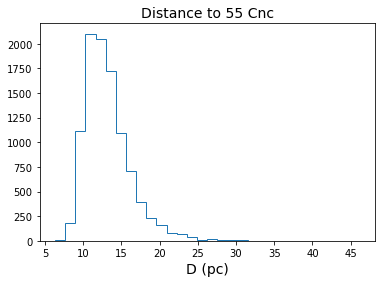

In [11]:
# Insert code here

p_mean = 0.079427
p_std = 0.016

p_gauss = np.random.normal(p_mean,p_std,size=10000) #Insert code to draw 1000 random number from a Gaussian distribution with a mean of p_mean and a standard deviation of p_std
d_gauss = 1/p_gauss

# Plot a histogram of the distances
plt.hist(d_gauss,30,histtype='step') #missing last parenthesis
plt.xlabel('D (pc)',fontsize=14)
plt.title('Distance to 55 Cnc',fontsize=14)

# Calculate the mean and standard deviation of the distances
mean_d = np.mean(d_gauss) # missing np
std_d = np.std(d_gauss) #mean_d in place of d_gauss
print('Distance to 55 Cnc {:0.3f}+-{:0.3f} pc'.format(mean_d,std_d))

### Putting It All Together

Now let's use what we have seen to estimate the uncertainty on a more complicated calculated quantity.

In lab 3 you used the distribution of redshifts for galaxies in the Virgo cluster to calculate the mass of the Virgo cluster. But what is the uncertainty on your mass estimate? You could use the propogation of errors calculation to figure this out, but you would need to know how to estimate the uncertainty on the standard deviation, and would need to account for the fact that each galaxy has a different uncertainty on its redshift.

Another way is to use the random number generators described above. The idea is as follows:

Suppose we had four galaxies with the following redshifts:
* z$_1$ = 0.0502 $\pm$ 0.001
* z$_2$ = 0.0562 $\pm$ 0.002
* z$_3$ = 0.0579 $\pm$ 0.001
* z$_4$ = 0.0584 $\pm$ 0.007

The standard deviation of the redshifts of these four galaxies is 0.0033, which implies a cluster mass of M$_{cluster}$=10.2 $\times$ 10$^{14}$ M$_{sun}$. 

Lets imagine a series of measurements of the redshifts of each galaxy. Each measurement of the redshift is a random number drawn from the Gaussian distribution with a mean set by the previous measurement and a stadard deviation set by the uncertainty.

* For galaxy 1 we draw a random number from a Gaussian distribution with a mean of 0.0502 and a standard deviation of 0.001 and record this as z$_{1a}$. 
* For galaxy 2 we draw a random number from a Gaussian distribution with a mean of 0.0562 and a standard deviation of 0.002 and record this as z$_{2a}$. 
* For galaxy 3 we draw a random number from a Gaussian distribution with a mean of 0.0579 and a standard deviation of 0.001 and record this as z$_{3a}$. 
* For galaxy 4 we draw a random number from a Gaussian distribution with a mean of 0.0584 and a standard deviation of 0.007 and record this as z$_{4a}$. 

This leaves us with four numbers (z$_{1a}$, z$_{2a}$, z$_{3a}$, z$_{4a}$), each representing a simulated measurement of the redshift for the corresponding galaxy. Suppose we do this exercise and are left with the following list of redshifts:

* z$_{1a}$ = 0.05099
* z$_{2a}$ = 0.05647
* z$_{3a}$ = 0.05770
* z$_{4a}$ = 0.05879

This distribution of redshifts has a standard deviation of $\sigma_z$ = 0.0030, which is similar to, but slightly different from our answer above. If we plug this value into our mass formula the result is M$_{cluster}$ = 8.6 $\times$ 10$^{14}$ M$_{sun}$.

If we draw another redshift from each of these four distributions we might get the following values:

* z$_{1b}$ = 0.04970
* z$_{2b}$ = 0.05803
* z$_{3b}$ = 0.05582
* z$_{4b}$ = 0.06905

which has $\sigma_z$ = 0.0070, which corresponds to M$_{cluster}$ = 46.8 $\times$ 10$^{14}$ M$_{sun}$.

Now imagine repeating this exercise 100 (or 1000 or 10000) more times. We would end up with 100 (or 1000 or 10000) values of M$_{cluster}$. As with the distance calculation above, the mean of these M$_{cluster}$ values represents our best estimate of the true value of M$_{cluster}$, while the standard deviation of these 100 (or 1000 or 10000) values represents our estimate of the uncertainty on M$_{cluster}$

Confused? That is okay. We will walk through all of this again using python code.

> **Q:** In the space below copy your SDSS SQL query for galaxies in the Virgo cluster. To this query, add that you want `zerr` in addition to `z`.

In [13]:
### Insert SDSS SQL query here

query_string ='''select
  z, zerr
from specobj
where
  ra between 175 and 185 and
  dec between 7 and 17 and
  class = 'galaxy' and
  z between .002 and .006 and
  zWarning = 0

'''
data = SDSS.query_sql(query_string,verbose=False)
print(data)

     z          zerr    
----------- ------------
0.002991138 1.805791e-05
 0.00302945 6.026896e-06
0.003304078 7.780374e-06
0.002463984  6.79247e-06
0.003434411 5.455039e-06
0.003021275 5.880267e-06
0.003073977  5.88614e-06
0.002704951 6.374183e-06
0.004067285 1.890763e-05
        ...          ...
0.002861395 7.004871e-05
 0.00477051 2.273964e-05
0.004641557 9.769967e-05
0.004670391 4.056848e-05
 0.00543042 8.373381e-05
0.005894653 9.880004e-06
 0.00524799 4.033529e-05
0.005138387 1.265246e-05
0.005222305 1.471533e-05
0.003066019 5.390498e-05
Length = 49 rows


To make our lives easier, let's write a function that returns the mass of the cluster, given a list of redshifts as an input. 

> **Q:** The outline for a function that returns the mass of the cluster (`Mcluster`) is included below. The function takes a required input that is the list of redshifts (`redshifts`) and an optional input that is the radius of the cluster (`Rcluster`, with default value of `7.5e6`). Fill in the space with the code necessary for calculating the mass of the cluster. 

In [14]:
def cluster_mass(redshifts,Rcluster = 7.5e6): #Set up function definition
    G = 6.67e-8 #gravitational constant in cgs units
    Msun = 1.99e33 #mass of the Sun in cgs units
    c = 2.99e10 #speed of light in cgs units
    ly = 9.461e17 # light year, in units of cm
    Mcluster = 2*Rcluster*ly*(np.std(redshifts*c)**2)/G/Msun #Calculate Mcluster
    return Mcluster

> **Q:** In the space below, write out pseudo-code for our series of simulated mass measurements. What the code needs to do is randomly select a redshift for each galaxy in the cluster, based on its observed redshift and uncertainty, and then calculate the cluster mass based on this collection of redshifts. The process is repeated 100 (or 1000 or 10000) times, and in the end we want to know the mean and standard deviation of this distribution of cluster mass values. 

```

Insert pseudo-code here

```

> **Q:** Convert the algorithm you outlined in pseudo-code into actual code. What is the mass of the Virgo cluster, and what is the uncertainty on that mass?

Virgo Galaxy Cluster Mass : 1.37e+14 +- 8.90e+11 Msun


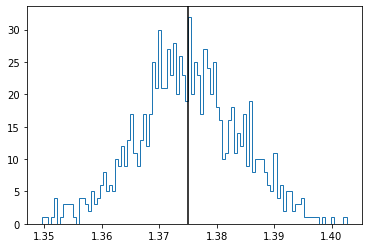

In [17]:
# Insert code here
masses = []

for i in range(1000):
    zvalues = []
    for z,zerr in zip(data['z'],data['zerr']):
        zvalues.append(np.random.normal(z,zerr,1))
    zvalues = np.array(zvalues)
    masses.append(cluster_mass(zvalues))
 
print('Virgo Galaxy Cluster Mass : {:0.2e} +- {:0.2e} Msun'.format(np.median(masses),np.std(masses)))
p = plt.hist(np.array(masses)/1e14,100,histtype='step')
plt.axvline(np.mean(masses)/1e14,color='k')

### To turn in this lab, share the lab with me using the *Share* button in the upper right.